# Hillary Clinton's Emails and Topic Modeling

A while back a batch of [Hillary Clinton's emails were released](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy), subsequently they were cleaned up and hosted on [Kaggle](https://www.kaggle.com/c/hillary-clinton-emails/) and lots of people started to explore the dataset. There's plenty of interesting scripts to explore on Kaggle, see [here](https://www.kaggle.com/chaojie/hillary-clinton-emails/exploring-hillary-clinton-s-emails) and [here](https://www.kaggle.com/ghassent/hillary-clinton-emails/sentiments-text-mining-and-more) for example. This is the notebook form of the script I posted which can be found [here](https://www.kaggle.com/blaahhrrgg/hillary-clinton-emails/latentsemanticindexing).

In this notebook, I have used a Latent Semantic Indexing (LSI) model to explore the dataset to see what could be found. Since I have ran the model on a corpus of only 1356 emails (the subset of emails with > 250 characters) I was not expecting to find too much but some of the topics are interesting and it provides a nice way of querying the dataset. I did quickly try a LDA model but as expected it didn't prove fruitful.

In [1]:
import re
import numpy as np
import pandas as pd
import networkx as nx

from gensim import corpora, models, similarities, utils

import matplotlib.pyplot as plt
% matplotlib inline

## Importing the data and cleaning the text

First we need to import the data and clean up the text a bit.

In [2]:
# columns we wish to import
usecols = ["DocNumber", "MetadataSubject", "MetadataTo", "MetadataFrom", "ExtractedBodyText"]

emails = pd.read_csv("output/Emails.csv", usecols=usecols,)

# examine the first few entries
emails.head()

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,ExtractedBodyText
0,C05739545,WOW,H,"Sullivan, Jacob J",NaN
1,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",Thx
3,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",NaN
4,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


In [3]:
# total number of emails in the dataset
print "Initial number of emails:", len(emails)

# remove any entries that do not have a lot of text
emails = emails[emails["ExtractedBodyText"].str.len() > 250]

# total number of emails in the dataset after filtering
print "Number of emails after filtering:", len(emails)

Initial number of emails: 7945
Number of emails after filtering: 1356


In [4]:
# convert emails to list for convenience
emails_body_text = emails["ExtractedBodyText"].tolist()

print emails_body_text[0]

Pis print.
-•-...-^
H < hrod17@clintonernailcom>
Wednesday, September 12, 2012 2:11 PM
°Russorv@state.gov'
Fw: Meet The Right-Wing Extremist Behind Anti-fvluslim Film That Sparked Deadly Riots
From [meat)
Sent: Wednesday, September 12, 2012 01:00 PM
To: 11
Subject: Meet The Right Wing Extremist Behind Anti-Muslim Film That Sparked Deadly Riots
htte/maxbiumenthal.com12012/09/meet-the-right-wing-extremist-behind-anti-musiim-tihn-that-sparked-
deadly-riots/
Sent from my Verizon Wireless 4G LTE DROID
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739559
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER. STATE-5CB0045251


Below is a helper function that will clean the text within each email

In [5]:
def cleanEmailText(text):
    
    # Removes any accents
    text = utils.deaccent(text)
    
    # Replace hypens with spaces
    text = re.sub(r"-", " ", text)
    
    # Removes dates
    text = re.sub(r"\d+/\d+/\d+", "", text)
    
    # Removes times
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text)
 
    # Removes email addresses
    text = re.sub(r"[\w]+@[\.\w]+", "", text)
    
    # Removes web addresses
    text = re.sub(r"/[a-zA-Z]*[:\/\/]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text)
    
    # Remove any bad characters
    clndoc = ''
    
    for eachLetter in text:
        if eachLetter.isalpha() or eachLetter == ' ':
            clndoc += eachLetter
        
    text = ' '.join(clndoc.split())
    
    return text

Now let's iterate through the list and clean each email

In [6]:
# let's iterate through the list and clean the text
for i, item in enumerate(emails_body_text):
    emails_body_text[i] = cleanEmailText(item)

and the emails now look like...

In [7]:
print emails_body_text[0]

Pis print H Wednesday September PMFw Meet The Right Wing Extremist Behind Anti fvluslim Film That Sparked Deadly RiotsFrom meatSent Wednesday September PMTo Subject Meet The Right Wing Extremist Behind Anti Muslim Film That Sparked Deadly Riotshttemaxbiumenthalcommeet the right wing extremist behind anti musiim tihn that sparked deadly riotsSent from my Verizon Wireless G LTE DROIDUS Department of StateCase No F Doc No CDate STATE DEPT PRODUCED TO HOUSE SELECT BENGHAZI COMMSUBJECT TO AGREEMENT ON SENSITIVE INFORMATION REDACTIONS NO FOIA WAIVER STATE CB


## Creating a corpus of documents

Now that the text has been cleaned we can create a corpus of documents using a bag of words representation. Since  the dataset isn't too large we can hold the corpus in memory, if the dataset was larger then we would read each document into the corpus one at a time, see the gensim tutorial [here](https://radimrehurek.com/gensim/tut1.html#corpus-streaming-one-document-at-a-time) for more details.

In [8]:
texts = [ [word for word in document.lower().split() ] for document in emails_body_text]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Next we perform [term frequency-inverse document frequency (tf-idf)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) to weight words according to how important they are. This can be used as a method of getting rid of common words such as "the", "is", "a", etc. but whether it works or not is a point of contention.

In [9]:
# perform tf-idf
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Now that we have a corpus we can start having some fun!

## Latent Semantic Indexing

The [Latent Semantic Indexing (LSI)](https://en.wikipedia.org/wiki/Latent_semantic_indexing) model is an indexing and retrieval method that is essentially a [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) that identifies patterns in the relationships between terms and concepts within the collection of text. It acheives this by performing a [singular value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) on the weighted term-document matrix, wikipedia has plenty of details [here](https://en.wikipedia.org/wiki/Latent_semantic_indexing#Mathematics_of_LSI).

In gensim, performing an LSI analysis is quite simple...

In [32]:
num_topics = 20

lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsi[corpus_tfidf]

Now we can examine the topics

In [33]:
lsi.show_topics()

[u'0.474*"pm" + 0.306*"secretarys" + 0.298*"am" + 0.238*"office" + 0.146*"room" + 0.138*"arrive" + 0.135*"route" + 0.133*"depart" + 0.129*"meeting" + 0.108*"en"',
 u'0.349*"pm" + 0.239*"secretarys" + 0.182*"am" + 0.160*"office" + -0.133*"the" + -0.132*"a" + -0.127*"of" + -0.126*"that" + -0.113*"he" + -0.107*"in"',
 u'0.315*"no" + 0.283*"benghazi" + 0.230*"redactions" + 0.230*"foia" + 0.229*"statecase" + 0.226*"commsubject" + 0.226*"cdate" + 0.226*"select" + 0.222*"sensitive" + 0.220*"doc"',
 u'0.207*"you" + 0.182*"i" + 0.146*"w" + 0.139*"your" + -0.121*"obama" + 0.119*"call" + 0.119*"me" + 0.119*"we" + 0.119*"please" + -0.109*"his"',
 u'0.290*"please" + 0.268*"reach" + 0.256*"laszczych" + 0.246*"youcdm" + 0.240*"methank" + 0.234*"joanne" + 0.197*"emergency" + 0.187*"toiv" + 0.183*"nora" + 0.178*"traveling"',
 u'0.353*"recipients" + 0.283*"mail" + 0.260*"e" + 0.233*"microsoft" + 0.223*"vancestategov" + 0.202*"message" + 0.154*"received" + 0.148*"system" + 0.142*"jan" + 0.141*"address"',

Some interesting topics, such as

In [12]:
lsi.show_topic(8)

[(-0.24136772922529628, u'uup'),
 (-0.20177993188840074, u'ireland'),
 (-0.1882156615962628, u'northern'),
 (-0.17928822310195908, u'dup'),
 (0.16236315721285988, u'she'),
 (0.15473380965722813, u'her'),
 (-0.14840862877747277, u'cameron'),
 (-0.12350319182802234, u'policing'),
 (-0.12251531428314355, u'vote'),
 (-0.11681897221601339, u'party')]

In [31]:
lsi.show_topic(2)

[(-0.31503445296851024, u'no'),
 (-0.28276316683635405, u'benghazi'),
 (-0.23006117023041786, u'foia'),
 (-0.23006117023041783, u'redactions'),
 (-0.22940031752541812, u'statecase'),
 (-0.22633664056994665, u'cdate'),
 (-0.22632651849732854, u'commsubject'),
 (-0.22604475885418365, u'select'),
 (-0.22224786689484408, u'sensitive'),
 (-0.21997939573948505, u'doc')]

In [34]:
lsi.show_topic(18)

[(0.22782560672763652, u'haiti'),
 (-0.20446861580070946, u'percent'),
 (-0.18795842839139393, u'draft'),
 (-0.16755697813386572, u'afghan'),
 (-0.14811822635050961, u'mr'),
 (-0.13342261232649982, u'afghanistan'),
 (0.1243219906322878, u'he'),
 (0.10637949660578183, u'labour'),
 (-0.10499971146469463, u'obama'),
 (-0.097986127910885415, u'mcchrystal')]

## Similarity Queries

We can perform a [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to determine the similarity of two vectors, and thus the similarity of two documents.

This is particularly of use if you want to find emails which are most similar to a certain phrase or keyword you are interested in, for example "Israel", "Gaddafi" or "Benghazi" may all be interesting queries due to nature of the dataset.

This can be acheived quite easily in gensim with the following bit of code

In [15]:
index = similarities.MatrixSimilarity(corpus_lsi, num_features=num_topics)

Then we can construct a query, let's take the query "Cameron Belfast Ireland" as an example.

In [16]:
query = "Cameron Belfast Ireland"

query_bow = dictionary.doc2bow(query.lower().split())
query_lsi = lsi[query_bow]
sims = index[query_lsi]

Below is a list of 2-tuples of the form (document_number, document_similarity)

In [17]:
print(list(enumerate(sims)))

[(0, -0.0035539083), (1, -0.011903643), (2, -0.095228784), (3, 0.0066341404), (4, 0.013165804), (5, -0.016131822), (6, 0.0056482991), (7, 0.0061987489), (8, 0.0060039945), (9, -0.052692436), (10, 0.012692159), (11, -0.053841762), (12, -0.019711696), (13, -0.0047740825), (14, -0.010240667), (15, -0.0036303252), (16, 0.0056241741), (17, 0.03365998), (18, -0.020028895), (19, -0.001148571), (20, 0.032371648), (21, -0.0055452213), (22, 0.0035622865), (23, 0.040478092), (24, 0.04684557), (25, -0.012478283), (26, 0.038864885), (27, -0.012095571), (28, 0.0026503229), (29, -0.0075936178), (30, -0.00049831718), (31, 0.0023849979), (32, -0.020806264), (33, 0.0051346663), (34, 0.0027896538), (35, -0.00063433824), (36, -0.0097244848), (37, -0.014389839), (38, 0.014291906), (39, -0.0013805225), (40, -0.032406017), (41, -0.015286509), (42, 0.015829321), (43, 0.043847501), (44, 0.016374525), (45, 0.023932077), (46, -0.0058049043), (47, -0.014026336), (48, 0.0095643457), (49, 0.0087766871), (50, 0.0056

We can sort them to find the most pertinent documents

In [18]:
sims = sorted(enumerate(sims), key=lambda item: -item[1])

print(sims)

[(743, 0.95507133), (739, 0.95189857), (736, 0.94741166), (735, 0.94531244), (636, 0.93972814), (645, 0.91106987), (737, 0.90836281), (823, 0.88798219), (878, 0.87212509), (546, 0.8481518), (564, 0.81090987), (729, 0.76639456), (876, 0.74689448), (561, 0.73133039), (630, 0.72511852), (660, 0.6641739), (954, 0.58938587), (545, 0.577209), (639, 0.54914778), (631, 0.52528596), (1206, 0.44901881), (635, 0.44199234), (566, 0.40380648), (574, 0.39613998), (1205, 0.36784357), (519, 0.33700091), (1093, 0.335152), (616, 0.32588252), (186, 0.32395387), (927, 0.31504068), (699, 0.30944687), (638, 0.30802691), (463, 0.28812993), (565, 0.26230407), (1323, 0.25897184), (650, 0.24482681), (1319, 0.24460919), (239, 0.23606515), (760, 0.23445556), (1162, 0.22440648), (802, 0.22063103), (676, 0.2193477), (462, 0.21884781), (1293, 0.21622886), (494, 0.21393535), (632, 0.20982713), (613, 0.2080771), (1296, 0.20543188), (953, 0.20534879), (926, 0.20450374), (951, 0.20297255), (245, 0.20145366), (444, 0.199

So document 743 is the most similar document to "Cameron Belfast Ireland", let's examine the content of this document

In [19]:
print emails_body_text[743]

tSCRIPT languageJavaScript SRChttpad emeadoubleclicknetadjNBabrieszxclickhttpadsguardiancouldeventngiTypeclickampFlightDampAdlDampTargetlDampValuesampRedirectordbNzdlpybfzocfybnvaqggtAltSCRIPTgt It NOSCRIPTgt tAHREFhttpadsguardiancouldeventngTypeclickamp FlightDampAdl DampTargetIDampValuesamp Red irecthttpad emeadoubleclick netiumpN abrieabrie szxordbNzdl py bfzocfybnvaqggt ItIMG SRChttpad emeadoubleclicknetadNBabrieabrieszxordbNzdlpybfzocfybnyaqg BORDER WIDTH HEIGHTgtAltAgt tNOSCRIPTgtiaiiTuardiancouk V SearchStormont votes to take over Northern Irelandpolicing powersPower sharing finalised as assembly agrees to first justice minister since TroublesUlster Unionists oppose measure but Hillary Clinton welcomes assemblys yes voteA year search for a political settlement in Northern Ireland cleared its final hurdle today when unionists and nationalistsvoted to transfer policing and criminal justice powers to Belfast creating the provinces first justice minister since theTroubles erupted fo

It is an email about the troubles in Belfast, Ireland which is what we would anticpate.

## Representing the Corpus as a Network, Identification of Document Clusters

An ad-hoc method of finding clusters of documents is to utilise the above similarity index to find which documents in the corpus are similar to each other. This can be done by iterating through the corpus and creating a weighted adjacency matrix, where each entry $a_{ij}$ contains the cosine similarity between document $i$ and $j$.

In [20]:
size = len(emails_body_text)

adj_mat = np.zeros((size,size,))

k = 0
for query_doc in corpus_lsi:
    sims = index[query_doc]
    simvec = list(enumerate(sims))
    simInd = [sim[1] for sim in simvec]
    adj_mat[k,:] = simInd
    k += 1


Let's examine some of the entries

In [21]:
print adj_mat[0:5,0:5]

[[ 0.99999994  0.87198782  0.21052071  0.91468066  0.90033579]
 [ 0.87198788  1.          0.27970639  0.8814851   0.97237408]
 [ 0.21052071  0.27970636  1.          0.28305307  0.30603835]
 [ 0.91468066  0.8814851   0.28305307  0.99999994  0.89742875]
 [ 0.90033579  0.97237408  0.30603835  0.89742875  0.99999994]]


Now we can create a network plot where each document is a node and we will draw an edge if the similarity is above a certain threshold, say 0.85. We will only do this for 100 documents so we can see the result a bit more clearly.

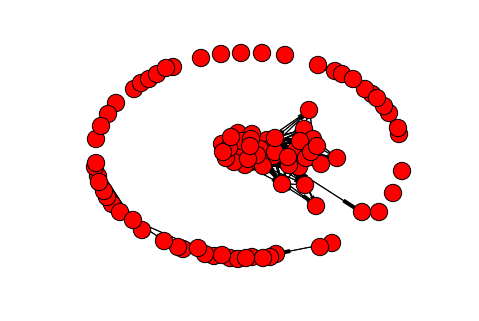

In [26]:
sim_thres = 0.75
num_nodes = 100

sub_mat = adj_mat[0:num_nodes,0:num_nodes]

# Set values above threshold equal to one, below equal to zero
high_value_indices = sub_mat > sim_thres
sub_mat[high_value_indices] = 1
sub_mat[~high_value_indices] = 0

D = nx.DiGraph(sub_mat)
nx.draw(D)

So it looks like there are some clusters that could be explored in a more systematic way.